<a href="https://colab.research.google.com/github/yuvalira/Monet_style_transfer/blob/main/data/prepare_dataset_monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset Preparation — Monet Style Transfer Project**

**Dataset: [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)**

The dataset contains two unpaired image domains stored in **TFRecord** format:

- **Monet-style paintings** (`monet_tfrec`)
- **Real-world landscape photos** (`photo_tfrec`)

Images are stored as **256×256 pixel** tensors in TFRecord format.  
Our goal is to convert real photos into Monet-style paintings.

---

The preprocessing in this notebook includes:

1. **Downloading** the dataset from Kaggle.
2. **Loading** Monet and photo datasets from TFRecords.
3. **Splitting** each domain into:
   - `train` set
   - `test` set  
   (split is defined via a manifest file for consistency across notebooks)
4. **Visualizing** a few examples from both domains.


## 1. Imports & Environment Setup

In [1]:
!pip install tensorflow-addons

In [2]:
!pip install keras==2.15.0 tensorflow==2.15.0 tensorflow-addons==0.23.0

Connect notebook to GitHub repo and make data importable

In [12]:
import os
import sys
import subprocess
from pathlib import Path

REPO_URL  = "https://github.com/yuvalira/Monet_style_transfer.git"
REPO_NAME = "Monet_style_transfer"
repo_path = Path("/content") / REPO_NAME

# Clone the repo if missing; otherwise fast-forward pull latest changes
if (repo_path / ".git").exists():
    subprocess.run(["git", "-C", str(repo_path), "pull", "--ff-only"], check=True)
else:
    subprocess.run(["git", "clone", REPO_URL, str(repo_path)], check=True)

# Work inside the repository directory
os.chdir(repo_path)
print("[CWD]", Path.cwd())

# Ensure `data/` is a Python package
(Path("data")).mkdir(parents=True, exist_ok=True)
(Path("data") / "__init__.py").touch(exist_ok=True)

# Add the repo to Python's import path
if str(repo_path) not in sys.path:
    sys.path.insert(0, str(repo_path))
print("[sys.path added]", repo_path)

# Import check
from data.data_splits import create_manifests, load_split
print("[Import] OK")

[CWD] /content/Monet_style_transfer
[sys.path added] /content/Monet_style_transfer
[Import] OK


Import dependencies

In [4]:
# Standard library
import sys
import random
from pathlib import Path

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Project modules
from data.data_splits import create_manifests, load_split

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Configure Kaggle API access

In [5]:
!pip -q install kaggle

import os, json
from google.colab import files

print("Please upload your kaggle.json (from https://www.kaggle.com/settings/account)")
uploaded = files.upload()  # choose kaggle.json
assert "kaggle.json" in uploaded, "kaggle.json is required."

os.makedirs("/root/.kaggle", exist_ok=True)
with open("kaggle.json", "r") as f:
    creds = json.load(f)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(creds, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("Kaggle API is configured.")

Please upload your kaggle.json (from https://www.kaggle.com/settings/account)


Saving kaggle.json to kaggle.json
Kaggle API is configured.


## 2. Load & Prepare Dataset
In this step, we download the dataset from the Kaggle competition, extract the zip archives, and organize them into a standard folder structure for TensorFlow TFRecords. We then verify that the extracted files are present and contain the expected number of shards. Finally, we generate manifest files that define the train/test split according to the chosen ratio, using a fixed random seed for reproducibility.


In [6]:
# Download the competition bundle
!kaggle competitions download -c gan-getting-started -p ./kaggle -q

# Unzip the main archive into ./kaggle
!unzip -q ./kaggle/gan-getting-started.zip -d ./kaggle

# Create target folders for TFRecords
!mkdir -p ./tfrecords/monet_tfrec ./tfrecords/photo_tfrec

# Some competitions bundle TFRecords inside their own zip files.
# Try to unzip monet_tfrec and photo_tfrec zips if they exist:
!if [ -f ./kaggle/monet_tfrec.zip ]; then unzip -q ./kaggle/monet_tfrec.zip -d ./tfrecords/monet_tfrec; fi
!if [ -f ./kaggle/photo_tfrec.zip ]; then unzip -q ./kaggle/photo_tfrec.zip -d ./tfrecords/photo_tfrec; fi

# If TFRecords were extracted as folders under ./kaggle (not zipped),
# copy them into the standard structure:
!if [ -d ./kaggle/monet_tfrec ]; then cp -r ./kaggle/monet_tfrec/* ./tfrecords/monet_tfrec/; fi
!if [ -d ./kaggle/photo_tfrec ]; then cp -r ./kaggle/photo_tfrec/* ./tfrecords/photo_tfrec/; fi

# Verify
import glob, os
monet_tfrec = glob.glob("./tfrecords/monet_tfrec/*.tfrec")
photo_tfrec = glob.glob("./tfrecords/photo_tfrec/*.tfrec")
print("Monet TFRecord shards:", len(monet_tfrec))
print("Photo TFRecord shards:", len(photo_tfrec))
assert len(monet_tfrec) > 0 and len(photo_tfrec) > 0, "TFRecord files not found. Check unzip paths."

Monet TFRecord shards: 5
Photo TFRecord shards: 20


In [7]:
LOCAL_TFREC_ROOT = str(Path("./tfrecords").resolve())
SPLITS_DIR = Path("data/splits")
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

create_manifests(
    gcs_path=LOCAL_TFREC_ROOT,  # local TFRecord root
    out_dir=str(SPLITS_DIR),
    train_ratio=0.9,
    seed=42
)

print("Manifests created under:", SPLITS_DIR)

Manifests created under: data/splits


In [8]:
from google.colab import files
import glob

# Get all manifest files from the 'data/splits' directory
manifest_files = glob.glob("data/splits/*.txt")

# Download each manifest file to the local machine
for file in manifest_files:
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Load TFRecord Datasets

In [9]:
BATCH_SIZE = 1
SEED = 42

train_photo = load_split(LOCAL_TFREC_ROOT, domain="photo", split="train", batch_size=BATCH_SIZE, shuffle=False, seed=SEED)
train_monet = load_split(LOCAL_TFREC_ROOT, domain="monet", split="train", batch_size=BATCH_SIZE, shuffle=False, seed=SEED)

test_photo  = load_split(LOCAL_TFREC_ROOT, domain="photo", split="test",  batch_size=BATCH_SIZE)
test_monet  = load_split(LOCAL_TFREC_ROOT, domain="monet", split="test",  batch_size=BATCH_SIZE)

## 4. Dataset Examples

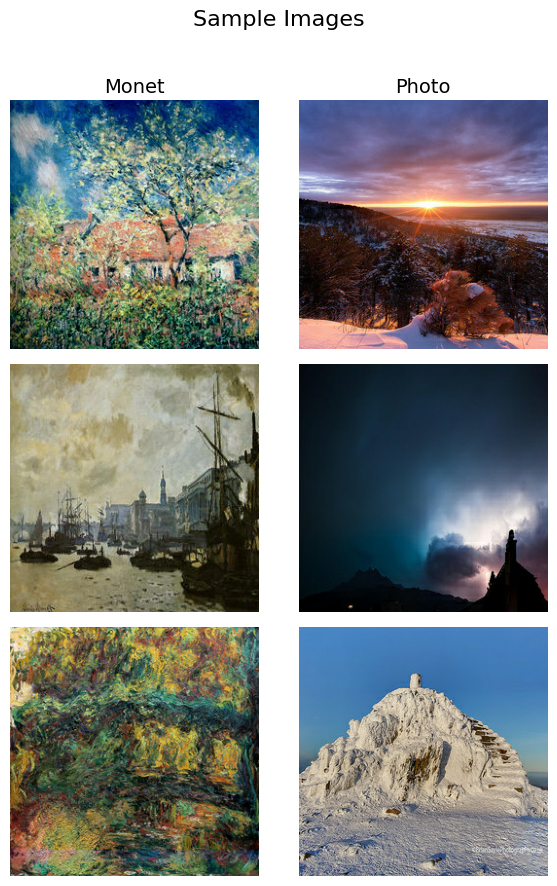

In [10]:
n_examples = 3  # number of rows
left_title = "Monet"
right_title = "Photo"

# Take samples from datasets
monet_samples = list(test_monet.take(50))
photo_samples = list(test_photo.take(50))

# Randomly select pairs
pairs = list(zip(
    random.sample(monet_samples, n_examples),
    random.sample(photo_samples, n_examples)
))

fig, axes = plt.subplots(n_examples, 2, figsize=(6, 3 * n_examples))
fig.suptitle("Sample Images", fontsize=16)

for i, (monet_batch, photo_batch) in enumerate(pairs):
    for col, (batch, title) in enumerate([(monet_batch, left_title), (photo_batch, right_title)]):
        img = batch[0] if isinstance(batch, (tuple, list)) else batch
        if tf.rank(img).numpy() == 4:
            img = img[0]  # remove batch dim
        img = ((img + 1.0) * 0.5).numpy()  # scale [-1,1] -> [0,1]

        axes[i, col].imshow(img)
        axes[i, col].axis("off")
        if i == 0:  # set column titles only on top row
            axes[i, col].set_title(title, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()